# Classificação de Redes Sociais

Projeto da disciplina **SME0130 - Redes Complexas** administrada pelo Prof. Francisco Rodrigues

* Alexandre Eduardo de Souza Jesus - alexandre_souza@usp.br - 12559506

* Gustavo Silva de Oliveira - - 12567231

* Lucas Ivars Cadima Ciziks - luciziks@usp.br - 125599472

* Paloma Botto de Medeiros Serrão - palomabotto@usp.br - 12689641

---

In [13]:
# Importando Bibliotecas
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

## 1. Introdução

## 2. Metodologia

A análise será realizada da seguinte forma:

* Selecionar algumas redes sociais para análise (http://konect.cc/categories/Social/);
* Para cada rede social, gerar cerca de 30 redes a partir dos modelos ER, BA, WS, etc, com o mesmo N e grau médio da rede real;
* Calcular medidas para cada rede, tais como distância, transitividade, etc;
* Projetar em 2D as redes e os modelos;
* Classificar a rede de acordo com os modelos (https://iopscience.iop.org/article/10.1088/1742-5468/2010/11/P11015/pdf).

## 3. Análise das Redes Sociais

### 3.1. Funções Úteis

In [11]:
# Função para calcular o momento do grau
def momento(grafo, m):
  M = 0
  n = len(grafo)

  for node in grafo.nodes():
    M += grafo.degree(node) ** m
  
  return M / n

In [12]:
# Função para calcular a distribuição de graus
def degree_distribution(grafo):
  degrees = list(dict(grafo.degree()).values())
  degrees_array = np.array(degrees)

  max = np.max(degrees_array)
  min = np.min(degrees_array)
  kvalues = np.arange(min, max + 1)
  Pk = np.zeros(max + 1)

  for k in degrees_array:
    Pk[k] += 1

  Pk /= sum(Pk)
  return kvalues, Pk

In [14]:
# Função para calcular Entropia de Shannon
def shannon_entropy(grafo):
  k, Pk = degree_distribution(grafo)
  H = 0
  for p in Pk:
    if(p > 0):
      H = H - p * math.log(p, 2)
  return H

In [18]:
# Função para calcular medidas da rede
def medidas_da_rede(graph):
    avg_degree = momento(graph, 1)
    moment2 = momento(graph, 2)
    variance = moment2 - avg_degree**2
    avg_clustering = nx.average_clustering(graph)
    avg_shortest_path = nx.average_shortest_path_length(graph)
    assortativity = nx.degree_assortativity_coefficient(graph)
    transitivity = nx.transitivity(graph)
    entropy = shannon_entropy(graph)

    return  [avg_degree, moment2, variance, avg_clustering, avg_shortest_path, assortativity, transitivity, entropy]

In [19]:
# Função para gerar uma rede ER e coletar seu componente principal
def generate_ER(N, p):
    GER = nx.gnp_random_graph(N, p, seed=None, directed=False)
    Gcc = sorted(nx.connected_components(GER), key=len, reverse=True)
    GER = GER.subgraph(Gcc[0])

    GER = nx.convert_node_labels_to_integers(GER, first_label=0)

    return GER

# Função para gerar uma rede WS e coletar seu componente principal
def generate_WS(N, k, p):
    GWS = nx.watts_strogatz_graph(N, k, p, seed=None)
    Gcc = sorted(nx.connected_components(GWS), key=len, reverse=True)
    GWS = GWS.subgraph(Gcc[0])

    GWS = nx.convert_node_labels_to_integers(GWS, first_label=0)

    return GWS

# Função para gerar uma rede BA e coletar seu componente principal
def generate_BA(N, m):
    GBA = nx.barabasi_albert_graph(N, m)    
    Gcc = sorted(nx.connected_components(GBA), key=len, reverse=True)
    GBA = GBA.subgraph(Gcc[0])

    GBA = nx.convert_node_labels_to_integers(GBA, first_label=0)

    return GBA

In [66]:
# Função para gerar o conjunto de treinamento para classificar a rede social
def generate_train_set(N, avg_degree, n_networks = 30):
    X_train = []
    y_train = []
    
    p = avg_degree / (N - 1)
    m = int(avg_degree/2)

    for i in range(n_networks):
        graph_ER = generate_ER(N, p)
        X_train.append(medidas_da_rede(graph_ER))
        y_train.append(0.0)

        graph_WS = generate_WS(N, int(avg_degree), p)
        X_train.append(medidas_da_rede(graph_WS))
        y_train.append(1.0)

        graph_BA = generate_BA(N, m)
        X_train.append(medidas_da_rede(graph_BA))
        y_train.append(2.0)

    return np.array(X_train), np.array(y_train)

### 3.1. Petster Hamster Households

In [52]:
# Lendo rede social Petster http://konect.cc/networks/petster-hamster-household/
petster_graph = nx.read_edgelist("data/petster-hamster-household.txt", nodetype=int, data=(('weight',float),))
petster_graph = petster_graph.to_undirected()
petster_graph.remove_edges_from(nx.selfloop_edges(petster_graph))

# Selecionando maior componente
Gcc = sorted(nx.connected_components(petster_graph), key=len, reverse=True)
petster_graph = petster_graph.subgraph(Gcc[0])
petster_graph = nx.convert_node_labels_to_integers(petster_graph, first_label=0)

Number of nodes: 874
Number of edges: 4003


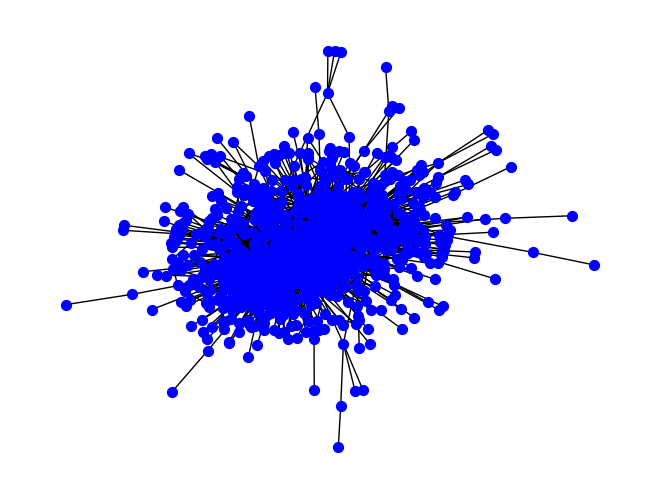

In [53]:
N = len(petster_graph)
M = petster_graph.number_of_edges()
print('Number of nodes:', N)
print('Number of edges:', M)

pos = nx.spring_layout(petster_graph)
nx.draw(petster_graph, pos, node_color="b", node_size=50, with_labels=False)

In [67]:
X_petster = np.array(medidas_da_rede(petster_graph))
X_train, y_train = generate_train_set(N, X_petster[0])

In [68]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_petster = X_petster.reshape(1, len(X_petster)) 
X_petster = scaler.transform(X_petster)
print('X_petster:', X_petster.shape)

X_petster: (1, 8)


In [69]:
# Aplicando Análise de Componentes Principais (PCA)
pca = PCA(n_components = 2)
X_r = pca.fit_transform(X_train)

# Compreendendo variância explicada
explained_variance = sum(pca.explained_variance_ratio_.tolist()[:2]) * 100
print(f"O PCA com 2 componentes principais explica {explained_variance:.4f}% da variância")

O PCA com 2 componentes principais explica 97.9843% da variância


In [64]:
X_r[y_train == 1.0, 0]

array([], shape=(0, 2), dtype=float64)

Text(0.5, 1.0, 'PCA Petster Network')

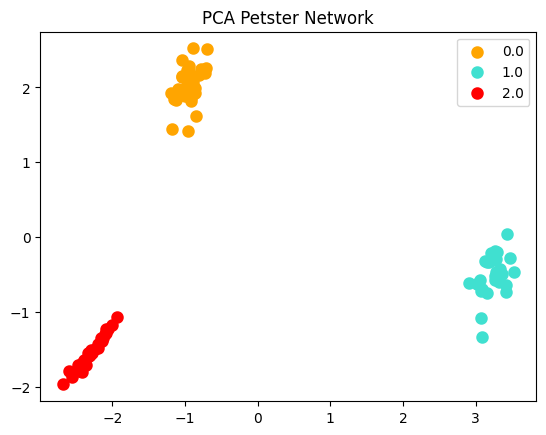

In [70]:
colors = ["orange", "turquoise", "red"]
lw = 3

for color, i in zip(colors, [0.0, 1.0, 2.0]):
    plt.scatter(
        X_r[y_train == i, 0], X_r[y_train == i, 1], color=color, lw=lw, label=i
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA Petster Network")

In [71]:
# Aplicando modelo KNN com 5 vizinhos
k = 5
model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
model.fit(X_r, y_train)

# faz a predição no conjunto de teste
X_petster = pca.transform(X_petster)
y_pred = model.predict(X_petster) 
cl = ['ER','WS','BA']
print('Classe:', cl[int(y_pred)])

Classe: BA


### 3.3. Orkut

In [ ]:
http://konect.cc/networks/orkut-links/

### 3.4. Google+

In [ ]:
http://konect.cc/networks/ego-gplus/

### 3.5. Twitter

In [ ]:
http://konect.cc/networks/twitter/

### 4. Conclusão

### 5. Referências Bibliográficas

* http://konect.cc/

* https://iopscience.iop.org/article/10.1088/1742-5468/2010/11/P11015/pdf